In [1]:
!pip install pdf2image

  Using cached pdf2image-1.17.0-py3-none-any.whl.metadata (6.2 kB)
Using cached pdf2image-1.17.0-py3-none-any.whl (11 kB)


In [1]:
from pdf2image import convert_from_path, convert_from_bytes
from pdf2image.exceptions import (
    PDFInfoNotInstalledError,
    PDFPageCountError,
    PDFSyntaxError
)
images = convert_from_path('test1.pdf')

In [2]:
def convert_xyxyxyxy_2_xyxy(points):
    x1,y1=points[0]
    x2,y2=points[2]
    return x1,y1,x2,y2

[2024/04/06 16:52:36] ppocr DEBUG: Namespace(alpha=1.0, alphacolor=(255, 255, 255), benchmark=False, beta=1.0, binarize=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='/Users/macos/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='/Users/macos/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_dir=None, e2e_pgnet_mo

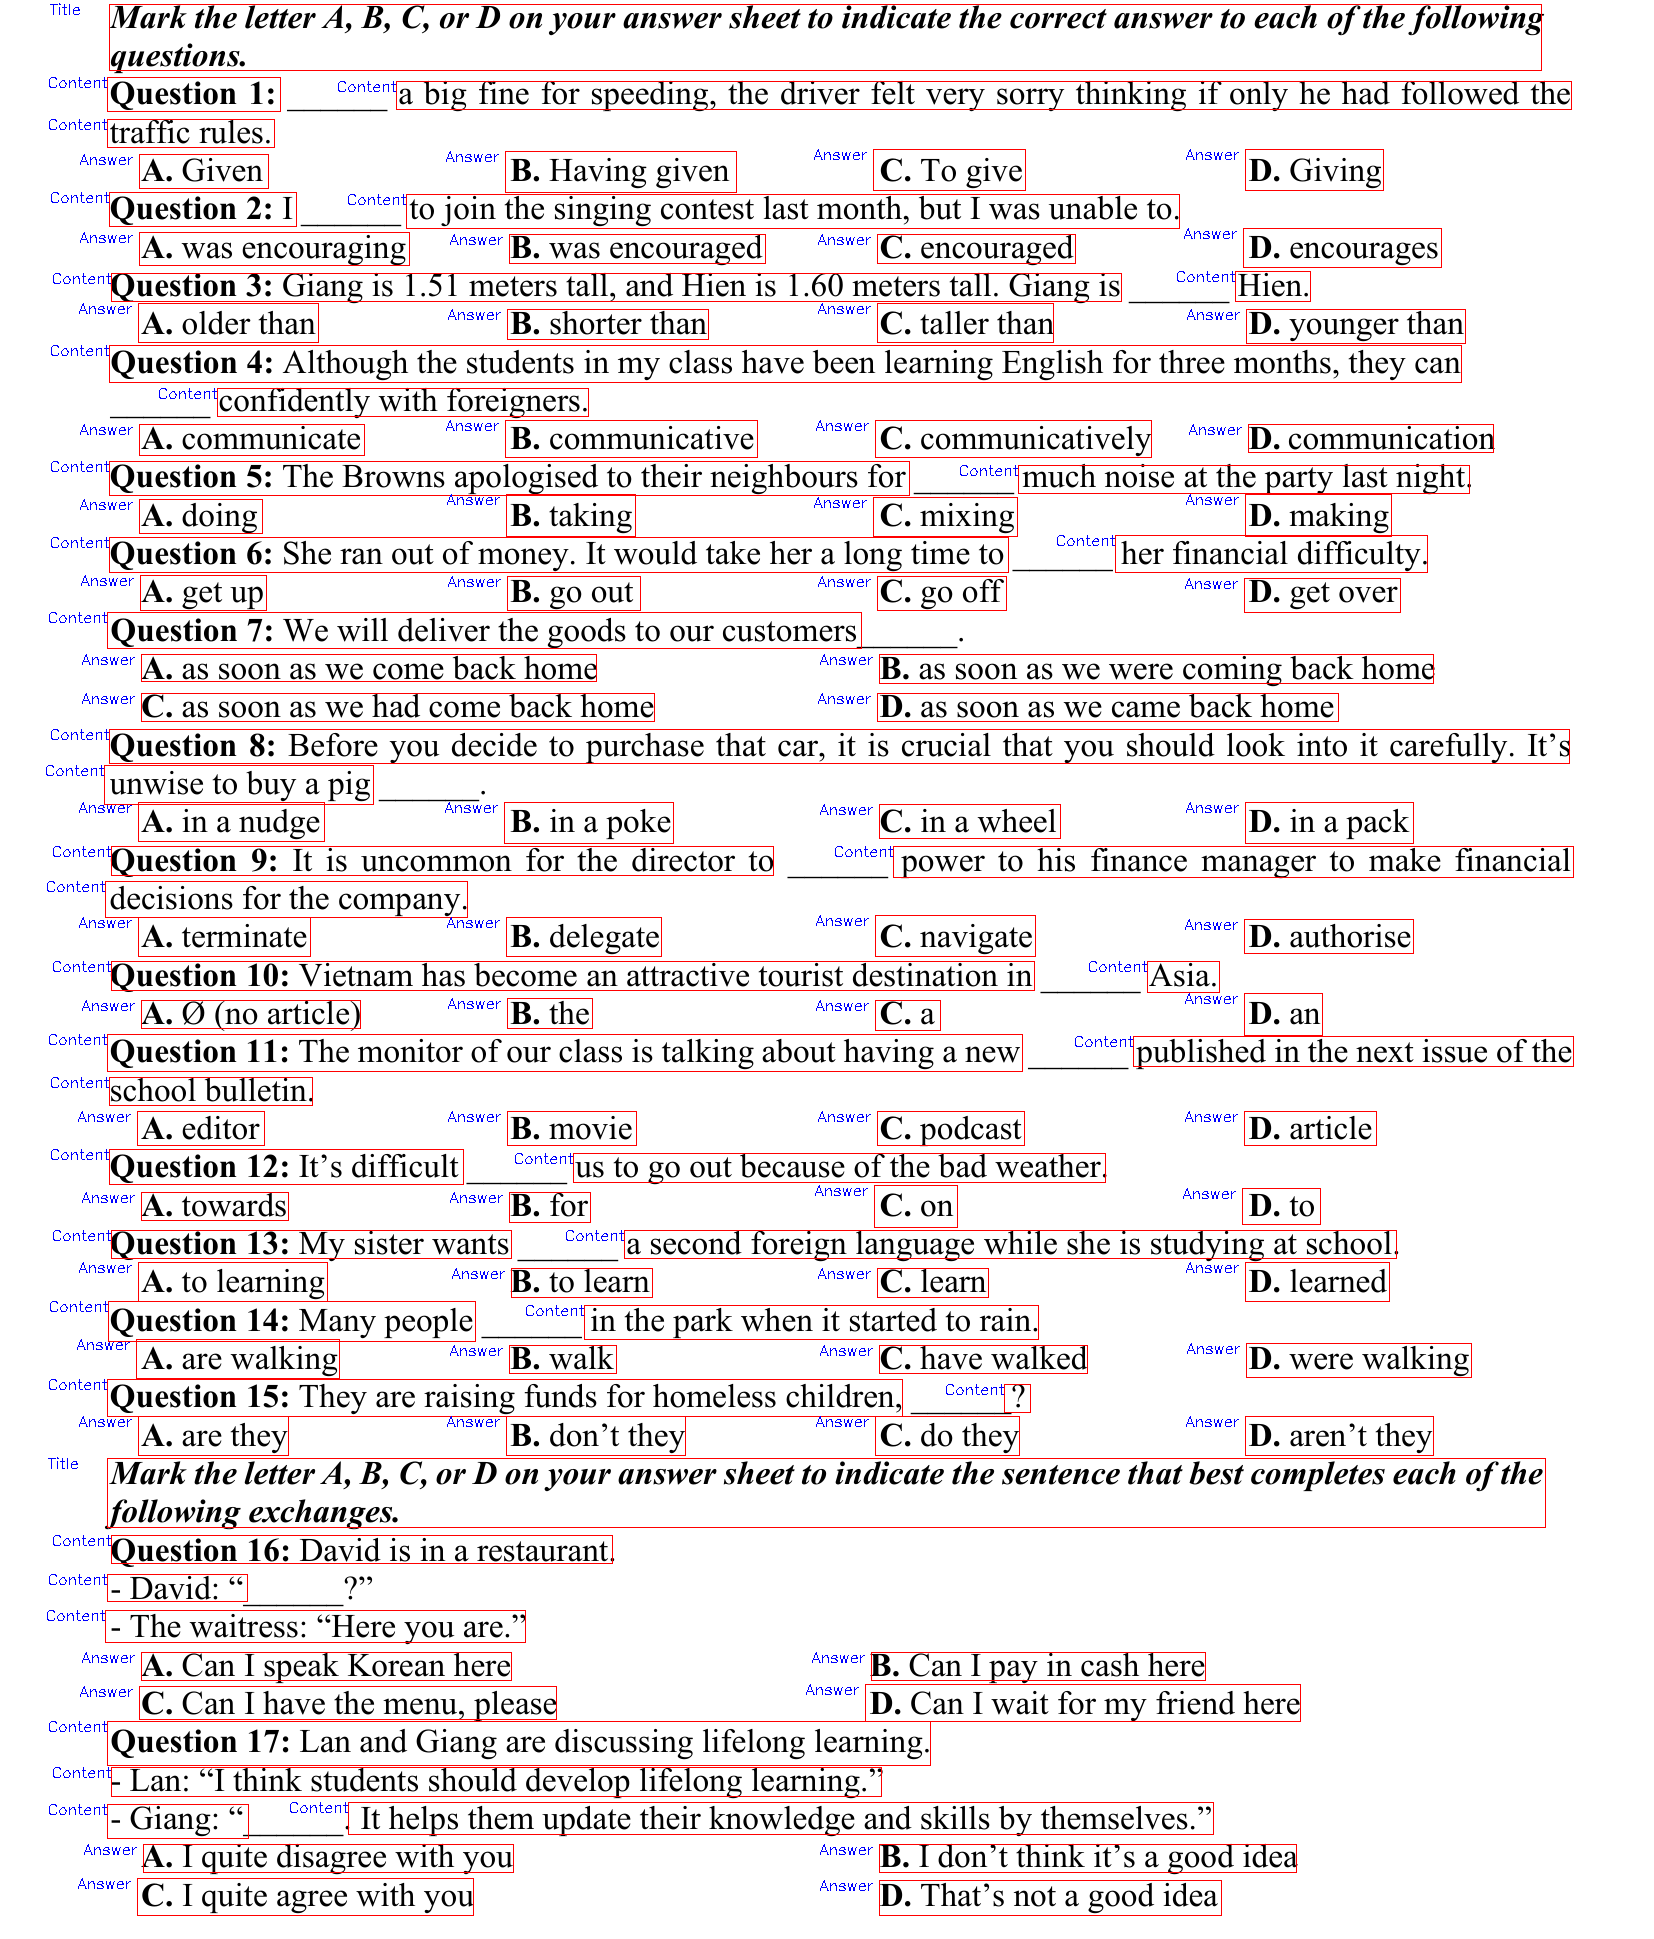

[2024/04/06 16:52:55] ppocr DEBUG: dt_boxes num : 108, elapsed : 0.3279438018798828
[2024/04/06 16:52:56] ppocr DEBUG: cls num  : 108, elapsed : 0.4964466094970703
[2024/04/06 16:53:18] ppocr DEBUG: rec_res num  : 108, elapsed : 21.756470203399658


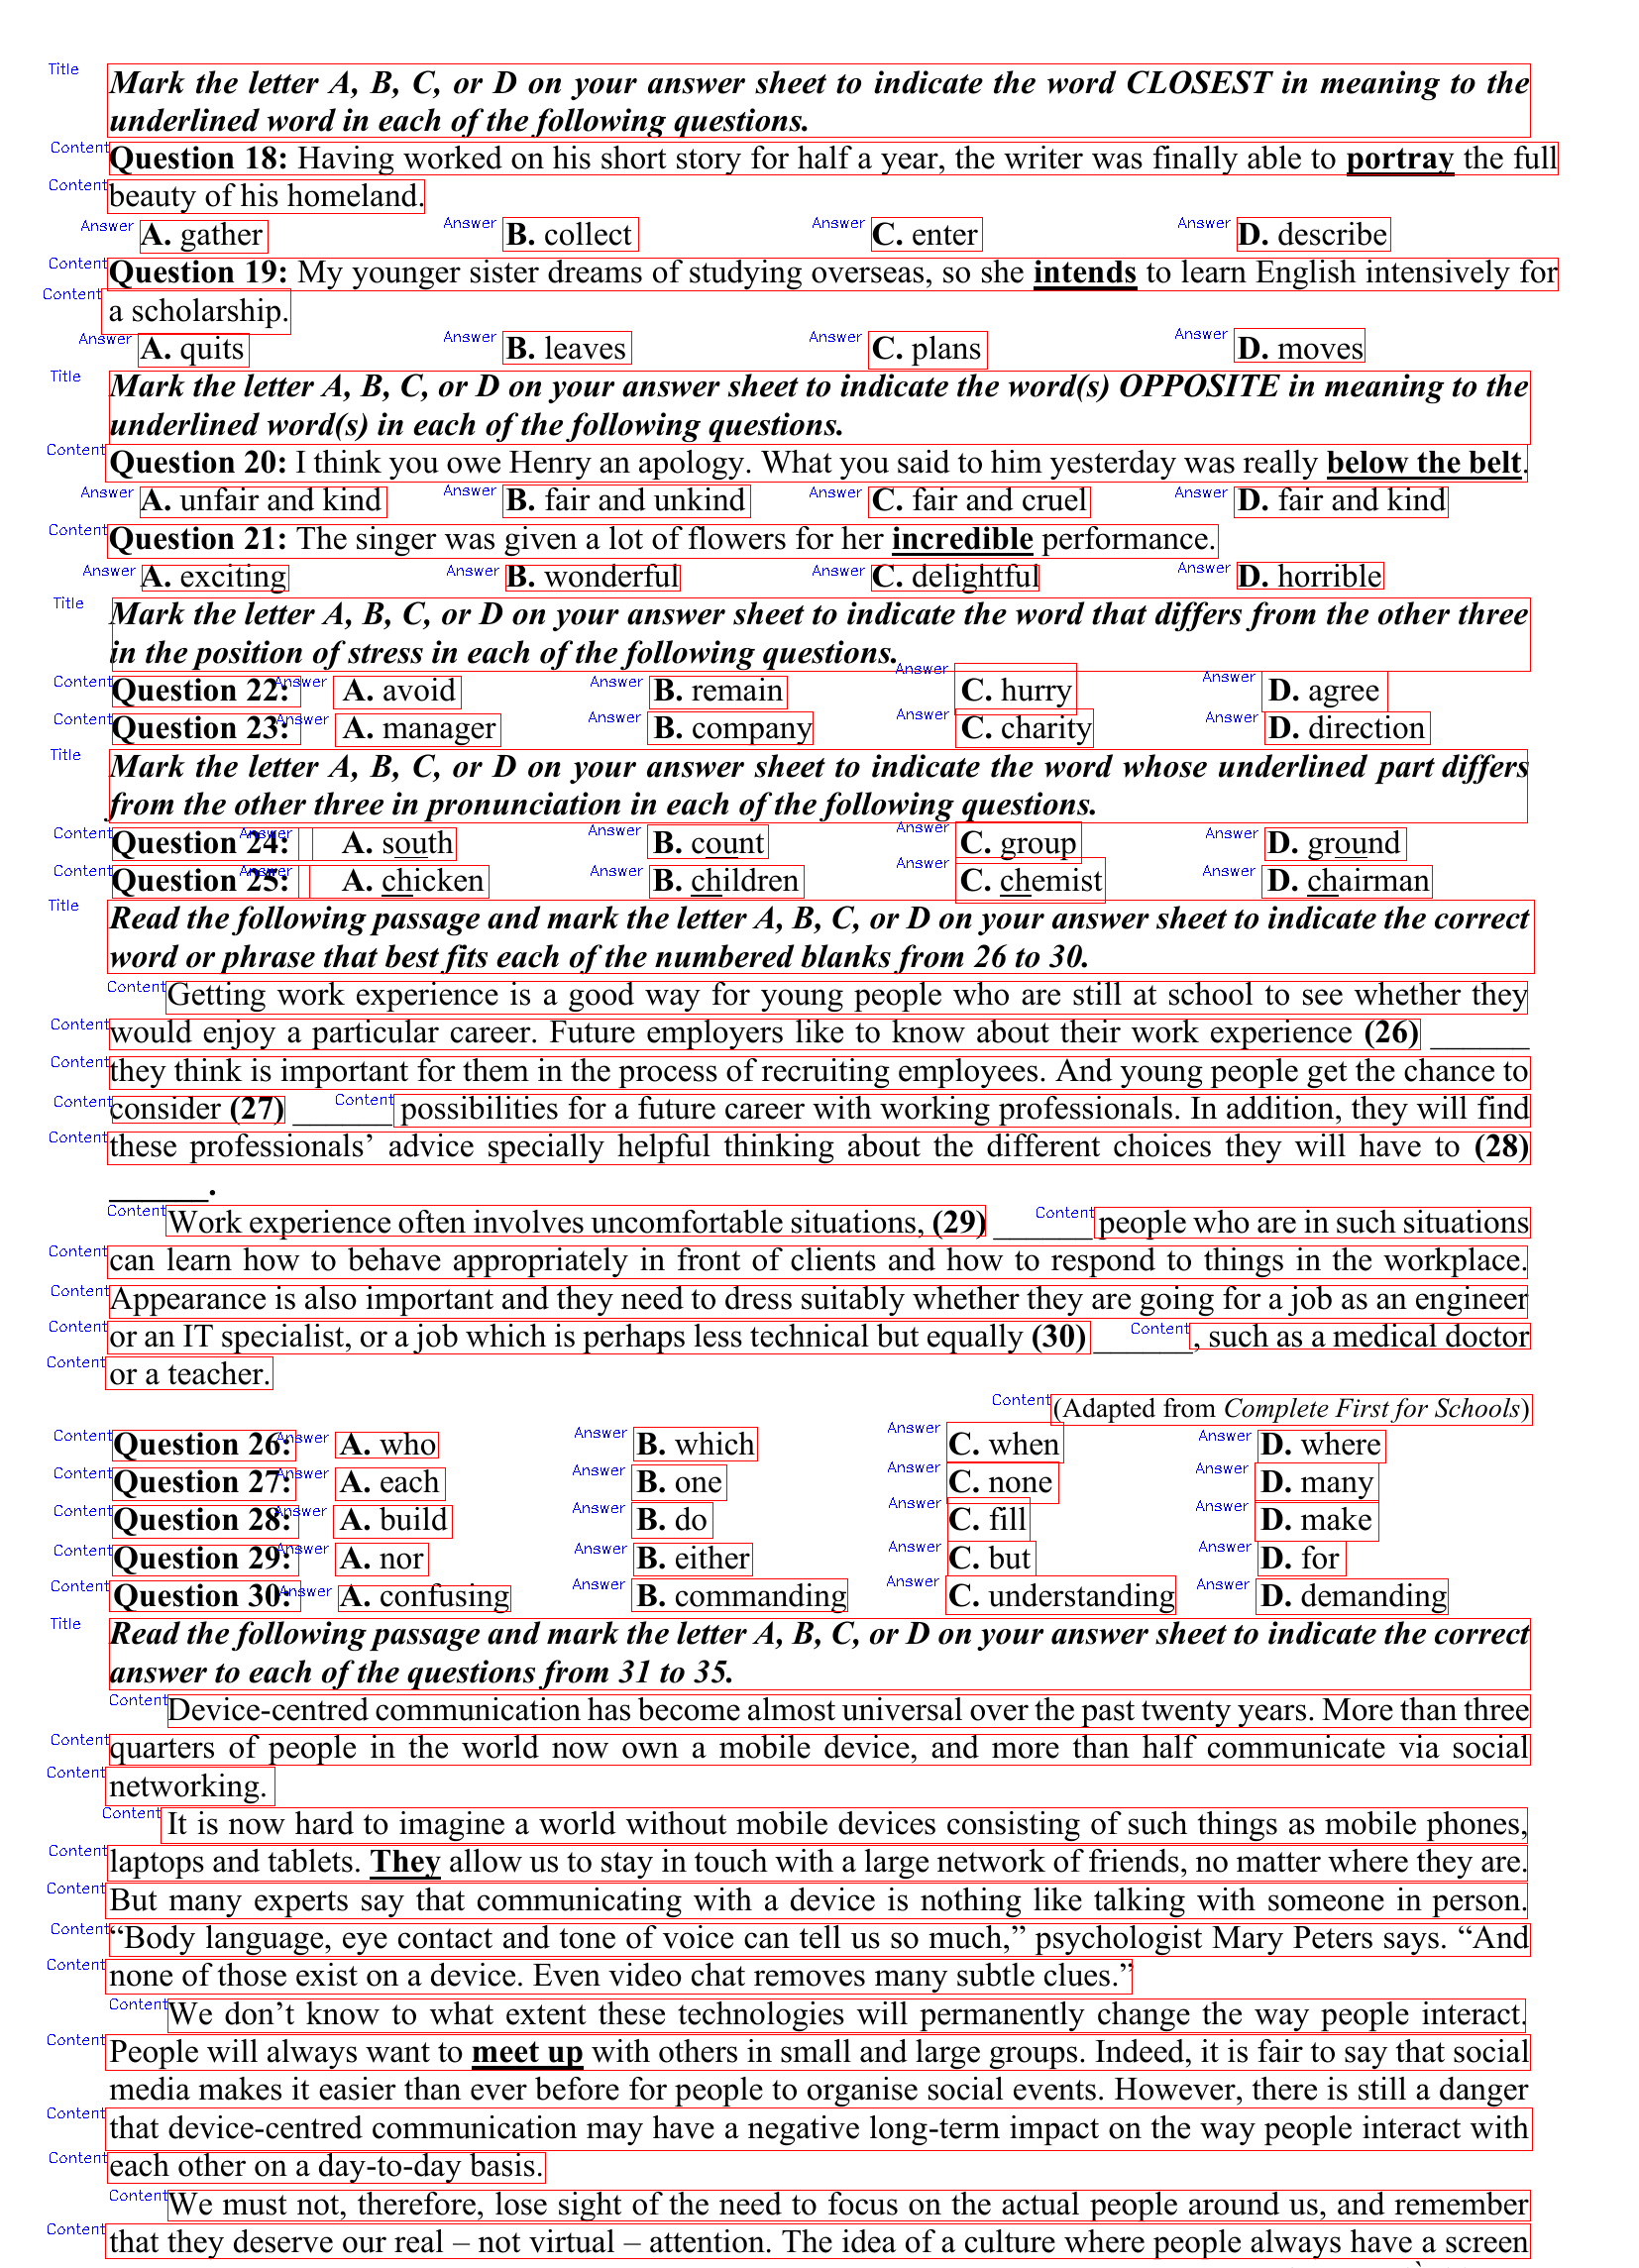

[2024/04/06 16:53:18] ppocr DEBUG: dt_boxes num : 80, elapsed : 0.3495810031890869
[2024/04/06 16:53:19] ppocr DEBUG: cls num  : 80, elapsed : 0.4200751781463623
[2024/04/06 16:53:40] ppocr DEBUG: rec_res num  : 80, elapsed : 21.266905784606934


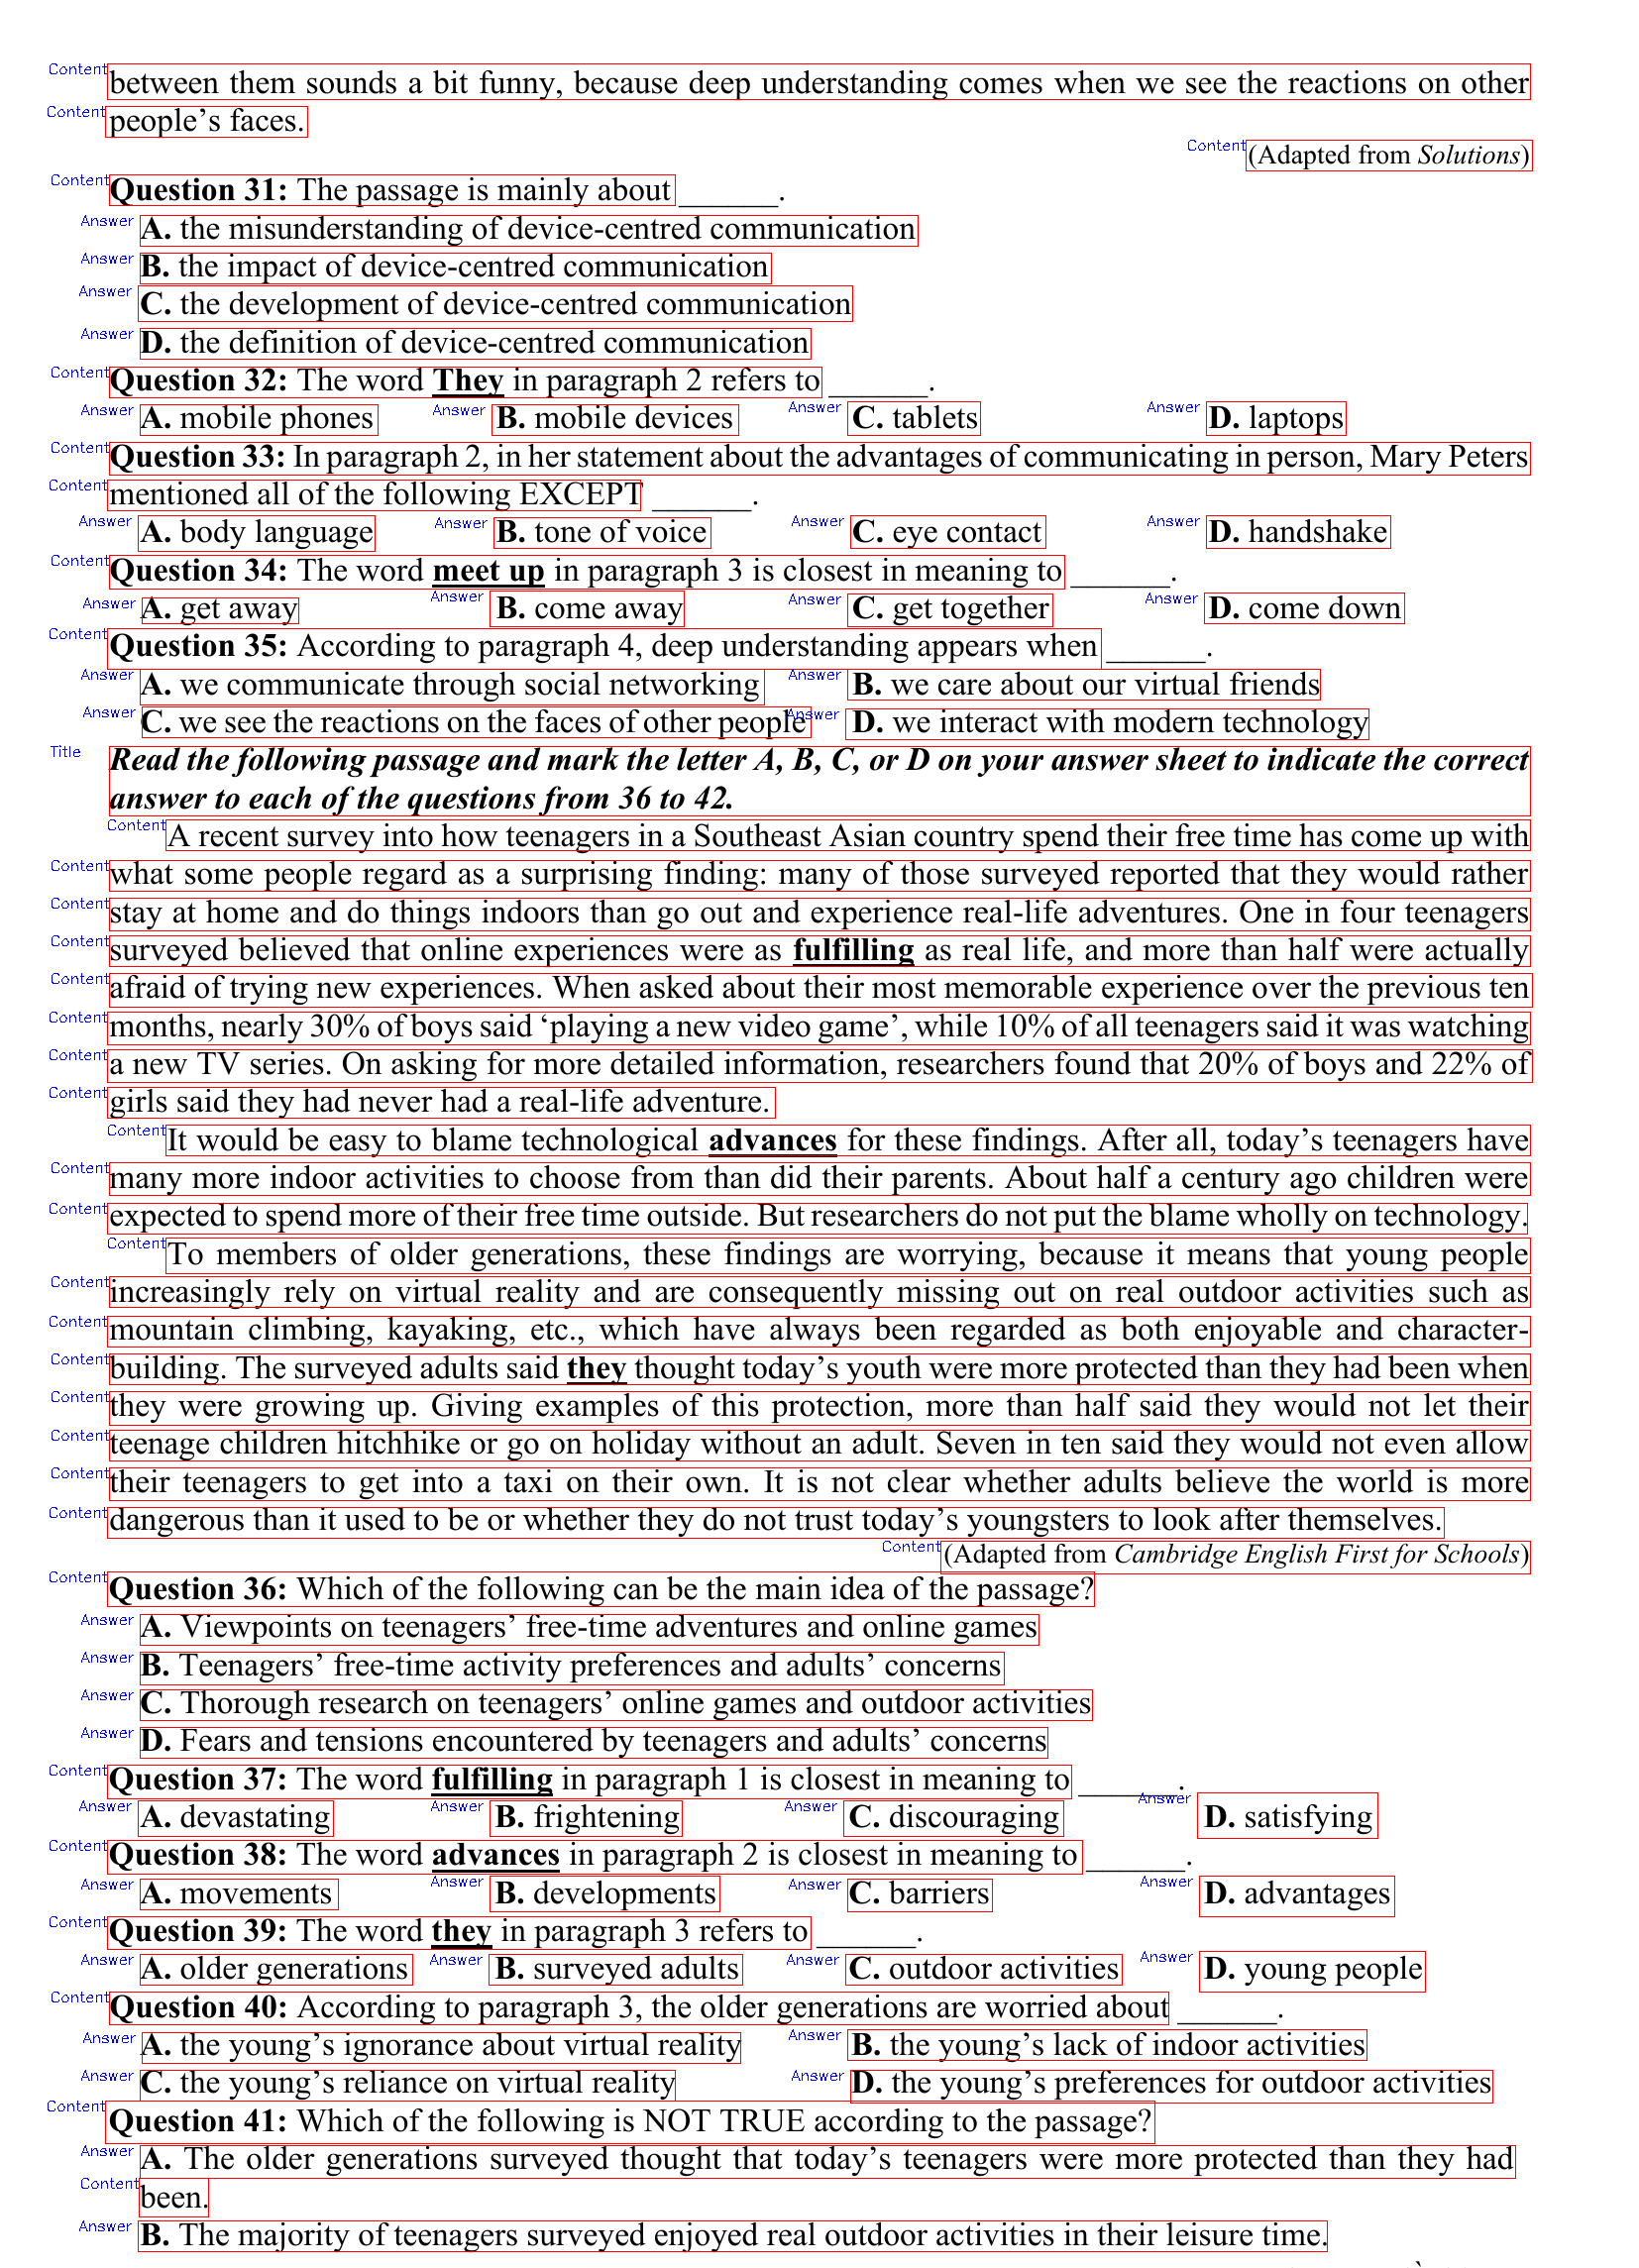

[2024/04/06 16:53:41] ppocr DEBUG: dt_boxes num : 63, elapsed : 0.32178401947021484
[2024/04/06 16:53:41] ppocr DEBUG: cls num  : 63, elapsed : 0.3348679542541504
[2024/04/06 16:53:59] ppocr DEBUG: rec_res num  : 63, elapsed : 17.618069887161255


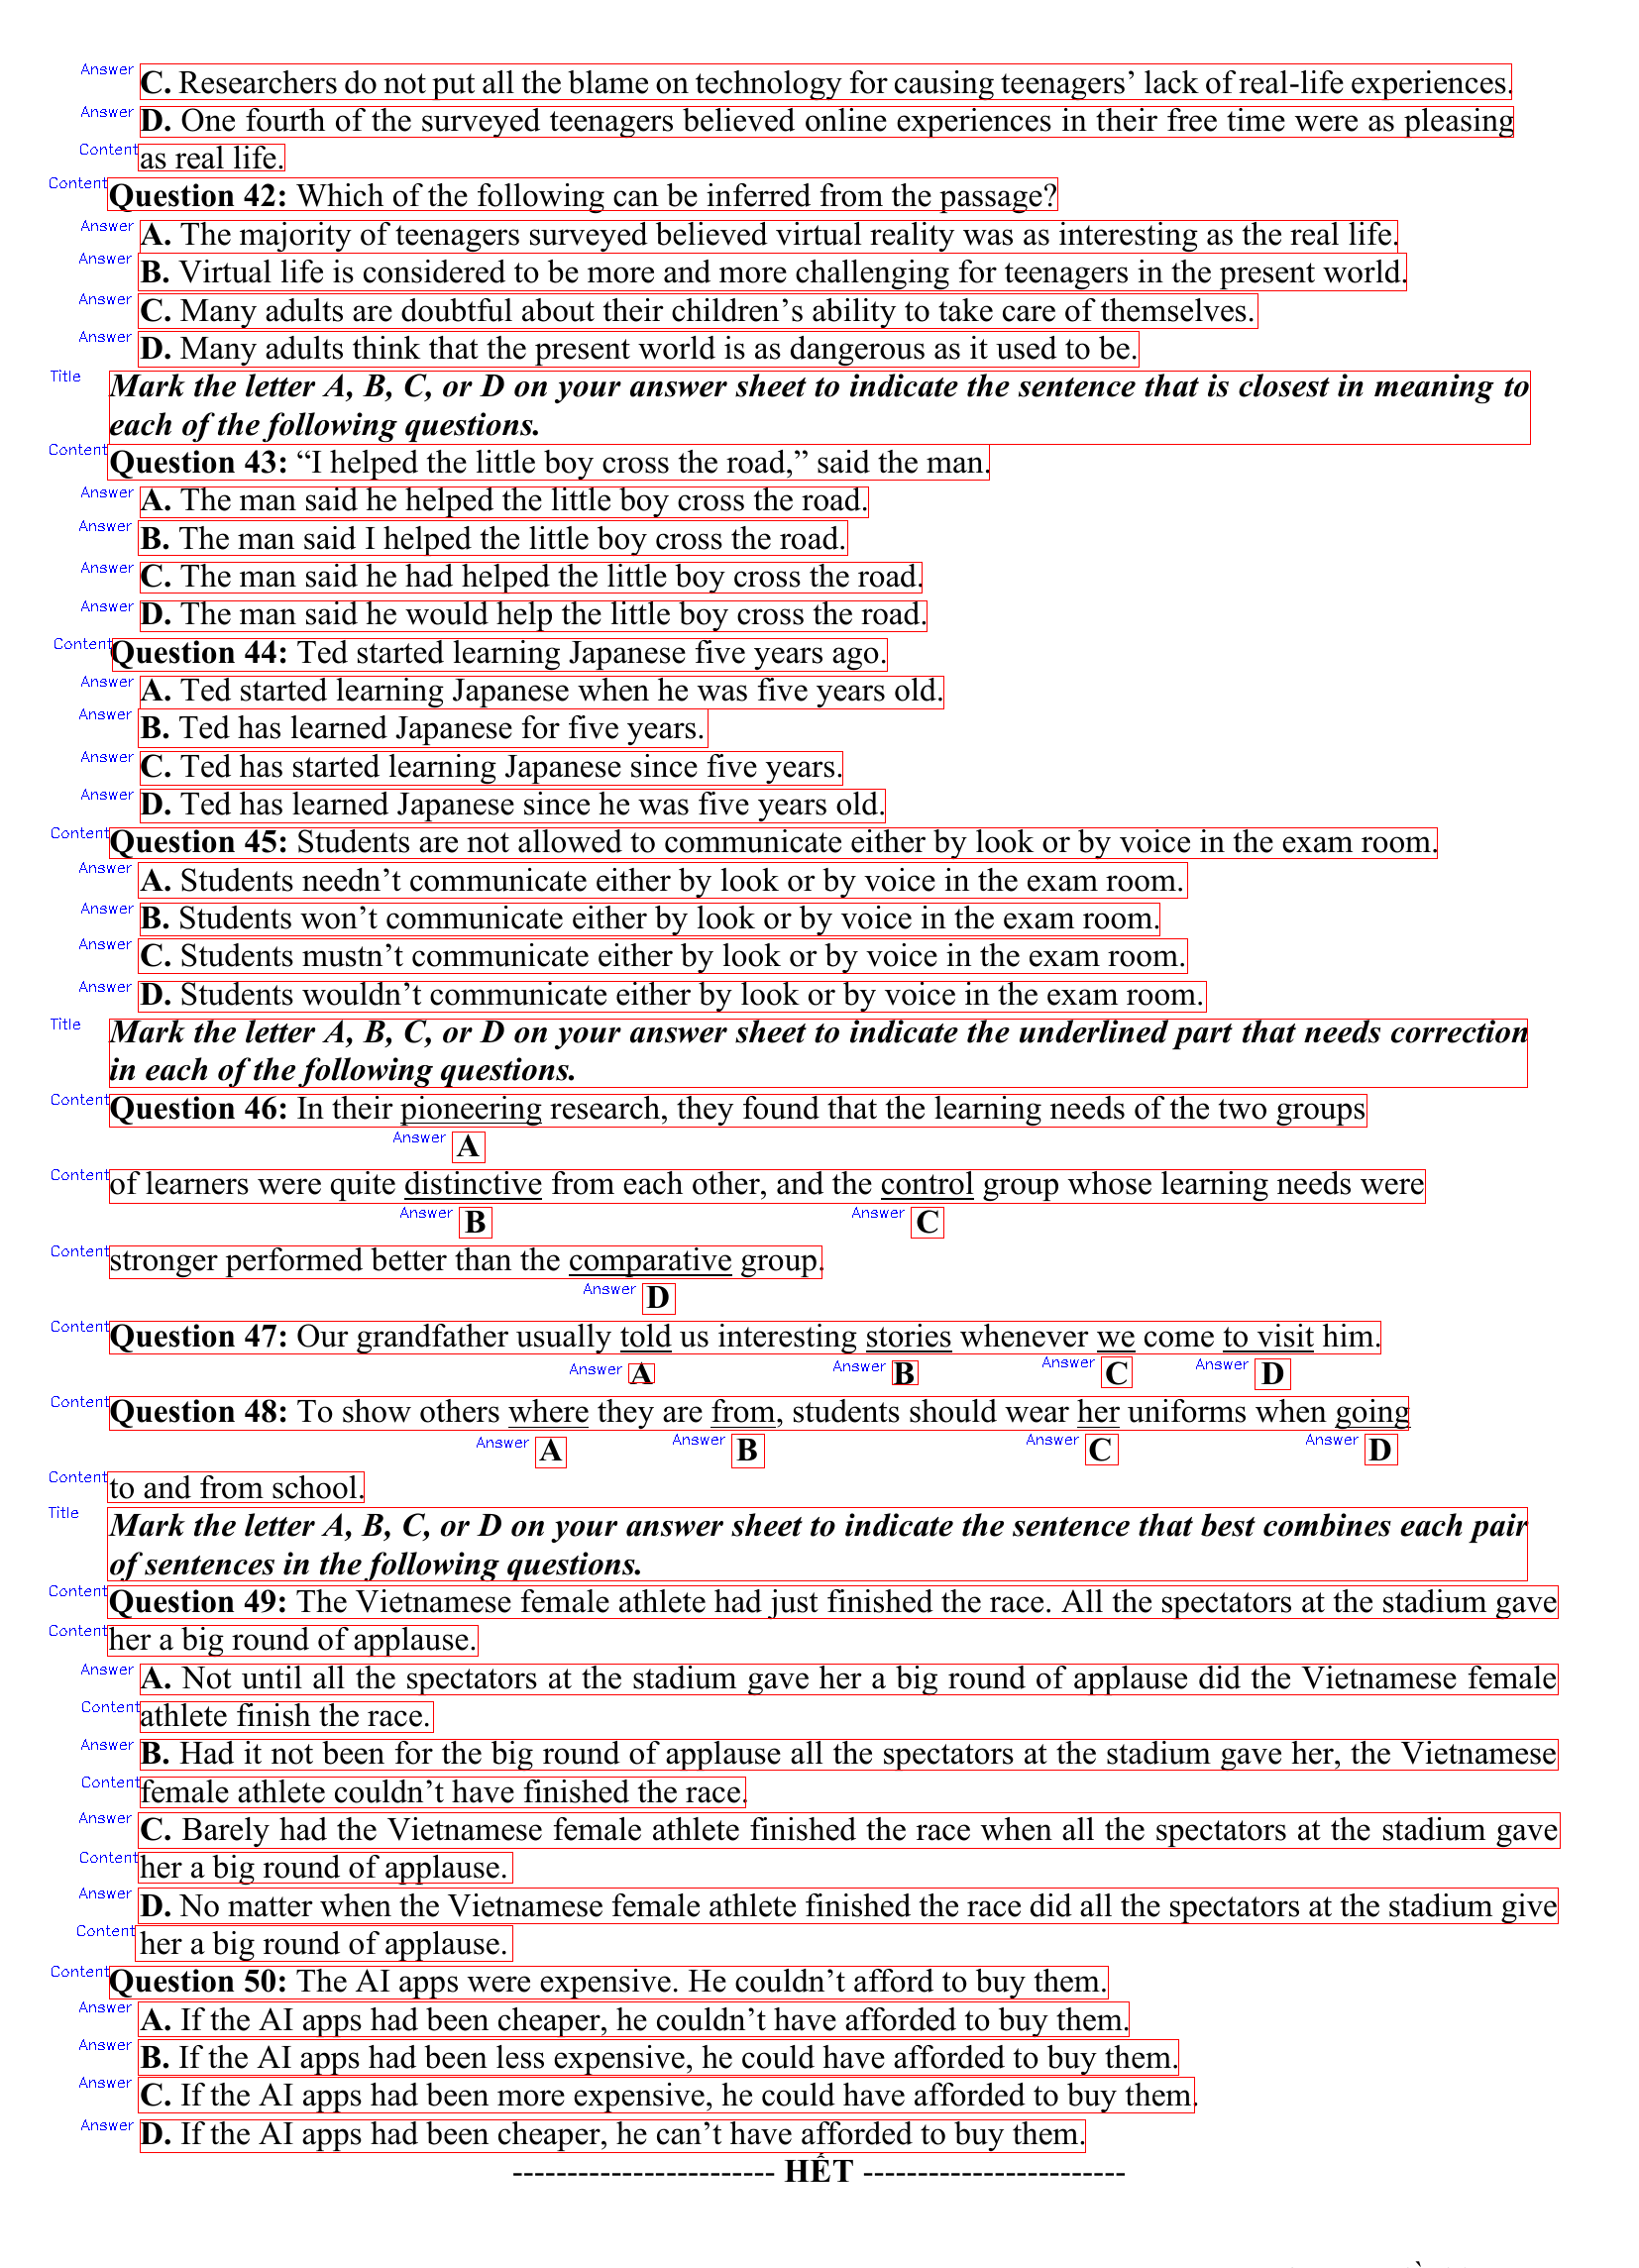

In [132]:
from paddleocr import PaddleOCR,draw_ocr
import numpy as np
import cv2
from PIL import Image
# Paddleocr supports Chinese, English, French, German, Korean and Japanese.
# You can set the parameter `lang` as `ch`, `en`, `french`, `german`, `korean`, `japan`
# to switch the language model in order.
ocr = PaddleOCR(use_angle_cls=True, lang='en',verbose=False) # need to run only once to download and load model into memory
Results=[]
for page,image in enumerate(images):
    Flag=False
    pos=None
    text_s=None
    flag_answer=False
    text_p=None
    image=np.array(image)
    h,w=image.shape[:2]
    # print(h,w)
    if page==0:
        image=image[300:h-100,:]
    else:
        image=image[:h-50,:]
    image=cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
    result = ocr.ocr(image, cls=True)
    for idx in range(len(result)):
        res = result[idx]
        for line in res:
            check={"pos":None,"text":None,"page":None,"label":None}
            points=line[0]
            box=list(map(int,convert_xyxyxyxy_2_xyxy(points)))
            check["pos"]=box
            check["text"]=line[1][0]
            check["page"]=page
            if Flag:
                check["label"]="title"
                check["text"]=text_s + " " + check["text"]
                x1,y1,x2,y2=pos
                x3,y3,x4,y4=check["pos"]
                check["pos"]=[x1,y1,x2,y4]
                cv2.putText(image,"Title",(x1-60,y1+10),cv2.FONT_HERSHEY_SIMPLEX,0.5,(255,0,0),1)
                cv2.rectangle(image,(x1,y1),(x2,y4),(0,0,255),1)
                Results.append(check)
                pos=None
                Flag=False
            # print("check",check)
            if  "Mark the letter A, B, C, or D".lower() in line[1][0].lower() or "Read the following passage and mark the letter A, B, C" in line[1][0].lower():
                Flag=True
                pos=box
                text_s=line[1][0]
   
            elif "A." in line[1][0] or "B." in line[1][0] or "C." in line[1][0] or "D." in line[1][0] or "A"==line[1][0] or "B"==line[1][0] or "C"==line[1][0] or "D"==line[1][0]:
                check["label"]="Answer"
                cv2.putText(image,"Answer",(box[0]-60,box[1]+10),cv2.FONT_HERSHEY_SIMPLEX,0.5,(255,0,0),1)
                cv2.rectangle(image,(box[0],box[1]),(box[2],box[3]),(0,0,255),1)
                Results.append(check)

            else:
                if "HET" not in line[1][0] and text_s is None:
                    cv2.putText(image,"Content",(box[0]-60,box[1]+10),cv2.FONT_HERSHEY_SIMPLEX,0.5,(255,0,0),1)
                    cv2.rectangle(image,(box[0],box[1]),(box[2],box[3]),(0,0,255),1)
                    check["label"]="content"
                    Results.append(check)
                else:
                    text_s=None
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image=Image.fromarray(image)
    display(image)
        



[2024/04/10 21:55:25] ppocr DEBUG: dt_boxes num : 17, elapsed : 1.9811289310455322
[2024/04/10 21:55:26] ppocr DEBUG: cls num  : 17, elapsed : 0.8505046367645264
[2024/04/10 21:55:37] ppocr DEBUG: rec_res num  : 17, elapsed : 10.892428159713745


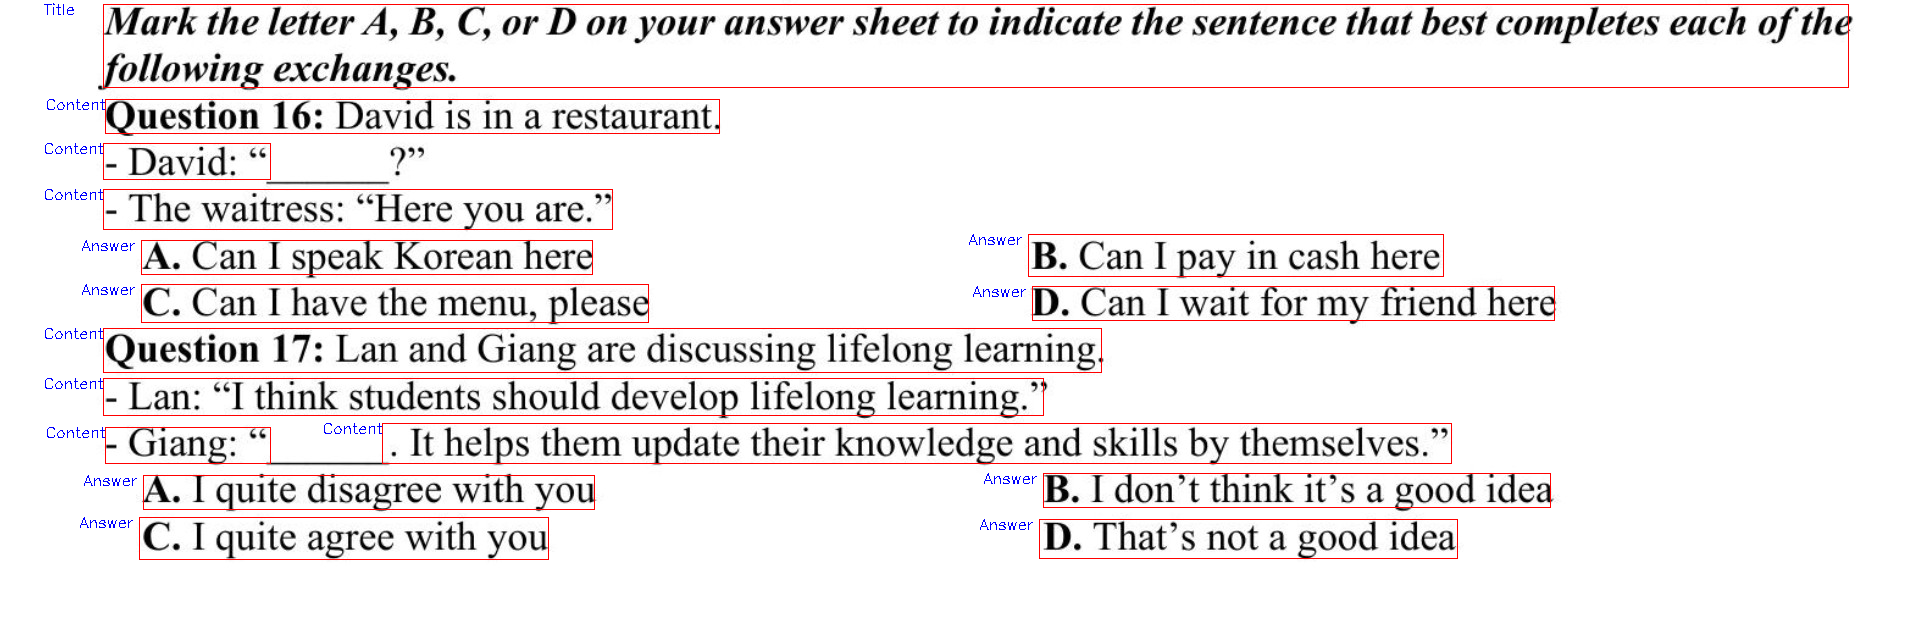

In [148]:
import numpy as np
image=Image.open("test.jpg")
image=cv2.cvtColor(np.array(image),cv2.COLOR_RGB2BGR)
result = ocr.ocr(image, cls=True)
for idx in range(len(result)):
    res = result[idx]
    for line in res:
        check={"pos":None,"text":None,"page":None,"label":None}
        points=line[0]
        box=list(map(int,convert_xyxyxyxy_2_xyxy(points)))
        check["pos"]=box
        check["text"]=line[1][0]
        check["page"]=page
        if Flag:
            check["label"]="title"
            check["text"]=text_s + " " + check["text"]
            x1,y1,x2,y2=pos
            x3,y3,x4,y4=check["pos"]
            check["pos"]=[x1,y1,x2,y4]
            cv2.putText(image,"Title",(x1-60,y1+10),cv2.FONT_HERSHEY_SIMPLEX,0.5,(255,0,0),1)
            cv2.rectangle(image,(x1,y1),(x2,y4),(0,0,255),1)
            pos=None
            Flag=False
        # print("check",check)
        if  "Mark the letter A, B, C, or D".lower() in line[1][0].lower() or "Read the following passage and mark the letter A, B, C" in line[1][0].lower():
            Flag=True
            pos=box
            text_s=line[1][0]

        elif "A." in line[1][0] or "B." in line[1][0] or "C." in line[1][0] or "D." in line[1][0] or "A"==line[1][0] or "B"==line[1][0] or "C"==line[1][0] or "D"==line[1][0]:
            check["label"]="Answer"
            cv2.putText(image,"Answer",(box[0]-60,box[1]+10),cv2.FONT_HERSHEY_SIMPLEX,0.5,(255,0,0),1)
            cv2.rectangle(image,(box[0],box[1]),(box[2],box[3]),(0,0,255),1)

        else:
            if "HET" not in line[1][0] and text_s is None:
                cv2.putText(image,"Content",(box[0]-60,box[1]+10),cv2.FONT_HERSHEY_SIMPLEX,0.5,(255,0,0),1)
                cv2.rectangle(image,(box[0],box[1]),(box[2],box[3]),(0,0,255),1)
                check["label"]="content"
            else:
                text_s=None
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image=Image.fromarray(image)
    display(image)

In [146]:
def is_integer(s):
    try:
        int(s)
        return True
    except ValueError:
        return False
# Khởi tạo danh sách để chứa nội dung merged
merged_content_total = []
merged_check=''
merge_title=[]
merged_answer_total = []
merged_answer_check=''
count_content=0
# Duyệt qua dữ liệu
for item in Results:
    label = item['label']
    if label == 'content':
        count_content+=1
        merged_check+=item['text']
        if len(merged_answer_check)>0:
            merged_answer_total.append(merged_answer_check)
        merged_answer_check=''

    elif label == 'Answer':
        count_content=0
        merged_answer_check+="\n"+item["text"]
        if len(merged_check)>0:
            merged_content_total.append(merged_check)
        merged_check=''
    elif label =="title":
        count_content=0
        merge_title.append(item["text"])

print("*"*20,merged_content_total[-1])
# for tit in merge_title:
#     print(tit)
#     for  quesion,ans in zip(merged_content_total,merged_answer_total):
#         print(quesion)
#         print(ans)
    
map_list_question={"Mark the letter A, B, C, or D on your answer sheet to indicate the correct answer to each of the following questions.":15,
                   "Mark the letter A, B, C, or D on your answer sheet to indicate the sentence that best completes each of the following exchanges.":2,
                   "Mark  the  letter  A,  B,  C,  or  D  on  your  answer  sheet  to indicate  the  word  CLOSEST  in  meaning  to  the underlined word in each of the following questions.":2,
                   "Mark the letter A, B, C, or D on your answer sheet to indicate the word(s) OPPOSITE in meaning to the underlined word(s) in each of the following questions.":2,
                   "Mark the letter A, B, C, or D on your answer sheet to indicate the word that differs from the other three in the position of stress in each of the following questions.":2,
                   "Mark  the  letter  A,  B,  C,  or  D  on  your  answer  sheet  to  indicate  the  word  whose  underlined part differs from the other three in pronunciation in each of the following questions.":2,
                   "Read the following passage and mark the letter A, B, C, or D on your answer sheet to indicate the correct word or phrase that best fits each of the numbered blanks from 26 to 30.":5,
                   "Read the following passage and mark the letter A, B, C, or D on your answer sheet to indicate the correct answer to each of the questions from 31 to 35.":5,
                   "Read the following passage and mark the letter A, B, C, or D on your answer sheet to indicate the correct answer to each of the questions from 36 to 42.":5,
                   "Mark the letter A, B, C, or D on your answer sheet to indicate the sentence that is closest in meaning to each of the following questions.":3,
                   "Mark the letter A, B, C, or D on your answer sheet to indicate the underlined part that needs correction in each of the following questions.":3,
                   "Mark the letter A, B, C, or D on your answer sheet to indicate the sentence that best combines each pair of sentences in the following questions.":2
                   
                   }

#Refine lại list content

#Question ( id, title, type, content, List<Answer>) 
id_save=0
CHECK=[15,2,2,2,2,2,5,5,8,3,5,5]
Cluster=[]
last_index=0
print("Len answer",len(merged_answer_total))
print(merge_title)
for title,size in zip(merge_title,CHECK):
    print(title)
    idx=merge_title.index(title)
    split_list_question = merged_content_total[id_save:size+id_save]
    split_list_answer=merged_answer_total[id_save:size+id_save]
    print("split_list_answer form {} to {}".format(id_save,size+id_save))
    print("split_list_question from {} to {}".format(id_save,size+id_save))
    if last_index<size:
        last_index = size
    else:
        last_index+=size

    id_save=last_index
    passage=''
    for ques,ans in zip(split_list_question,split_list_answer):
        question={"id":None,"title":None,"content":None,"list_answer":None}
        #check idx
        position=ques.find("Question")
        if "Question 50" in ques:
            print("------------------------",ques)
        if position==0:
            index=ques[9:11]
            if is_integer(index):
                index=int(index)
                question["id"]=index
            else:
                print("index",index)
                index=int(index[0])
                question["id"]=index
            question["title"]=title
            question["list_answer"]=ans
            question["content"]=passage + "\n" + ques
            print("question: ",question)
            Cluster.append(question)
        elif position>1:
            if len(ques)>250:
                print("Pos",position)
                passage=ques[:position]
                index=ques[position+9:position+11]
                question["title"]=title
                question["list_answer"]=ans
            else:
                
                question["title"]=title
                question["list_answer"]=ans
            question["content"]=passage + "\n" + ques[position:]
  
            if is_integer(index):
                index=int(index)
                question["id"]=index
            else:
                print("index",index)
                index=int(index[0])
                question["id"]=index
            print("question: ",question)
            Cluster.append(question)
            
                

                

                
                
                

        
            


        


******************** her a big round of applause.Question 50: The AI apps were expensive. He couldn't afford to buy them.
Len answer 55
['Mark the letter A, B, C, or D on your answer sheet to indicate the correct answer to each of the following questions.', 'Mark the letter A, B, C, or D on your answer sheet to indicate the sentence that best completes each of the following exchanges.', 'Mark the letter A, B, C, or D on your answer sheet to indicate the word CLOSEST in meaning to the underlined word in each of the following questions..', 'Mark the letter A, B, C, or D on your answer sheet to indicate the word(s) OPPOsITE in meaning to the underlined word(s) in each of the following questions.', 'Mark the letter A, B, C, or D on your answer sheet to indicate the word that differs from the other three in the position of stress in each of the following questions..', 'Mark the letter A, B, C, or D on your answer sheet to indicate the word whose underlined part differs from the other three 

In [144]:
Results

[{'pos': [109, 4, 1541, 70],
  'text': 'Mark the letter A, B, C, or D on your answer sheet to indicate the correct answer to each of the following questions.',
  'page': 0,
  'label': 'title'},
 {'pos': [107, 77, 280, 111],
  'text': 'Question 1:',
  'page': 0,
  'label': 'content'},
 {'pos': [396, 81, 1571, 109],
  'text': 'a big fine for speeding, the driver felt very sorry thinking if only he had followed the',
  'page': 0,
  'label': 'content'},
 {'pos': [107, 119, 274, 147],
  'text': 'traffic rules.',
  'page': 0,
  'label': 'content'},
 {'pos': [139, 154, 268, 188],
  'text': 'A. Given',
  'page': 0,
  'label': 'Answer'},
 {'pos': [505, 151, 736, 192],
  'text': 'B. Having given',
  'page': 0,
  'label': 'Answer'},
 {'pos': [873, 149, 1025, 190],
  'text': 'C. To give',
  'page': 0,
  'label': 'Answer'},
 {'pos': [1245, 149, 1383, 190],
  'text': 'D. Giving',
  'page': 0,
  'label': 'Answer'},
 {'pos': [109, 192, 296, 226],
  'text': 'Question 2: 1',
  'page': 0,
  'label': 'con

In [130]:
for item in Cluster:
    if "\nA"==item["list_answer"]:
        item["list_answer"]="\nA\nB\nC\nD"

In [131]:
Cluster

[{'id': 1,
  'title': 'Mark the letter A, B, C, or D on your answer sheet to indicate the correct answer to each of the following questions.',
  'content': 'Question 1:a big fine for speeding, the driver felt very sorry thinking if only he had followed thetraffic rules.',
  'list_answer': '\nA. Given\nB. Having given\nC. To give\nD. Giving'},
 {'id': 2,
  'title': 'Mark the letter A, B, C, or D on your answer sheet to indicate the correct answer to each of the following questions.',
  'content': 'Question 2: 1to join the singing contest last month, but I was unable to.',
  'list_answer': '\nA. was encouraging\nB. was encouraged\nC. encouraged\nD. encourages'},
 {'id': 3,
  'title': 'Mark the letter A, B, C, or D on your answer sheet to indicate the correct answer to each of the following questions.',
  'content': 'Question 3: Giang is 1.51 meters tall, and Hien is 1.60 meters tall. Giang is.Hien.',
  'list_answer': '\nA. older than\nB. shorter than\nC. taller than\nD. younger than'},
 